In [2]:
import os
import os.path as osp
import sys
import cv2
import numpy as np
import torch
import subprocess

import warnings
import difflib
import SimpleITK as sitk
import scipy.spatial
import matplotlib.pyplot as plt

from mmseg.apis import init_model, inference_model, show_result_pyplot
from mmengine.utils import mkdir_or_exist
from medpy.io import load as loadnii
from medpy.io import save as savenii
import plotly.express as px

In [9]:
#Crop from center
def center_crop_batch(images, crop_size):
    cropped_images = []
    extra_info_list = []
    images = np.transpose(images, (2, 0, 1))

    for image in images:
        height, width = image.shape[:2]
        crop_height, crop_width = crop_size

        # Calculate the starting point for the crop
        start_x = max(0, int((width - crop_width) / 2))
        start_y = max(0, int((height - crop_height) / 2))

        # Calculate the ending point for the crop
        end_x = min(width, start_x + crop_width)
        end_y = min(height, start_y + crop_height)

        # Calculate the border dimensions
        border_left = int(max(0, crop_width / 2 - width) / 2)
        border_right = int(max(0, crop_width / 2 - width) / 2)
        border_top = int(max(0, crop_height - height) / 2)
        border_bottom = int(max(0, crop_height - height) / 2)

        # Perform the center crop
        cropped = image[start_y:end_y, start_x:end_x]

        # Expand the border if necessary
        cropped = cv2.copyMakeBorder(cropped, border_top, border_bottom, border_left, border_right, cv2.BORDER_REPLICATE)

        cropped_images.append(cropped)

        # Store extra information about the original image size and crop dimensions
        extra_info = {
            'original_height': height,
            'original_width': width,
            'start_x': start_x,
            'start_y': start_y,
            'end_x': end_x,
            'end_y': end_y,
            'crop_height': crop_height,
            'crop_width': crop_width,
        }

        extra_info_list.append(extra_info)

    return np.array(cropped_images), extra_info

def insert_matrix_in_center(data, dims, ml=500, cs=112):
    x_s, y_s, z_s = dims
    
    min_x_axis = int(ml/2-x_s/2)
    max_x_axis = int(min_x_axis + x_s)
    min_y_axis = int(ml/2-y_s/2)
    max_y_axis = int(min_y_axis + y_s)

    T1_data_xyCtr = np.zeros((ml,ml,z_s))
    T1_data_xyCtr[min_x_axis:max_x_axis, min_y_axis:max_y_axis, :] = data
    T1_data_xyCtr = T1_data_xyCtr[int(ml/2-cs):int(ml/2+cs), int(ml/2-cs):int(ml/2+cs), :]
    
    T1_data_xyCtr  = np.transpose(T1_data_xyCtr , (2, 0, 1))
    
    return T1_data_xyCtr

def preprocessing_mri(images, label):
  flair, t1 = images
  dim_info = [flair.shape[0], flair.shape[1], flair.shape[2]]
  
  #Crop images
  c_flair = insert_matrix_in_center(flair, dim_info)
  c_t1 = insert_matrix_in_center(t1, dim_info)
  c_label = insert_matrix_in_center(label, dim_info)

  #Erase no info images
  sum_nozero = np.where(np.sum(c_flair, axis=(1, 2)) > 0)
  new_flair = c_flair[np.min(sum_nozero):np.max(sum_nozero)+1,:,:]
  new_flair = new_flair.astype(np.float64)
  new_flair = np.expand_dims(new_flair, 3)

  sum_nozero = np.where(np.sum(c_t1, axis=(1, 2)) > 0)
  new_t1 = c_t1[np.min(sum_nozero):np.max(sum_nozero)+1,:,:]
  new_t1 = new_t1.astype(np.float64)
  new_t1 = np.expand_dims(new_t1, 3)

  new_label = c_label[np.min(sum_nozero):np.max(sum_nozero)+1,:,:]
  new_label[new_label != 1] = 0
  new_label = new_label.astype(np.uint8)

  new2_flair = z_score(new_flair)
  new2_t1 = z_score(new_t1)


  f_image = np.concatenate((new2_flair, new2_t1), 3)
  #new_img = t1t2(new2_flair, new2_t1,True)
  #new_img = np.where(new_t1 == 0, 0, new_img)
  new_img = np.zeros(new_flair.shape, dtype=np.float64)
  f_image = np.concatenate((f_image, new_img), 3)
  
  
#   f_image = np.concatenate((new2_flair, new2_flair), 3)
#   new_img = np.zeros(new2_flair.shape, dtype=np.float64)
#   f_image = np.concatenate((f_image, new2_flair), 3)


  return f_image, new_label

def t1t2(a,b, truncate=False):
    div = np.divide(a,b, where=b!=0)
    if truncate:
        percentile_1 = np.percentile(div, 1)
        percentile_99 = np.percentile(div, 99)
        div = np.clip(div,percentile_1,percentile_99)
        normalized_data = (div - percentile_1) / (percentile_99 - percentile_1)
        return normalized_data
    return div

def z_score(data, lth = 0.02, uth = 0.98):
    
    temp = np.sort(data[data>0])
    lth_num = int(temp.shape[0]*0.02)
    uth_num = int(temp.shape[0]*0.98)
    data_mean = np.mean(temp[lth_num:uth_num])
    data_std = np.std(temp[lth_num:uth_num])
    data = (data - data_mean)/data_std
    
    return data

def minmax(image_data):
    percentile_1 = np.min(image_data)
    percentile_99 = np.max(image_data)
    normalized_data = (image_data - percentile_1) / (percentile_99 - percentile_1)
    return normalized_data

In [2]:
datos_path = "/home/electroscian/ownCloud/Competencia/Datos_ini/"
lista = os.listdir(datos_path)
lista.sort()
train_dirs = [0, 11, 17, 19, 2, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 4, 41, 49, 6, 8, #Ultrecht
                  50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, #Singapore
                  100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 126, 132, 137, 144] #Amsterdam

In [5]:
lista

['0',
 '1',
 '10',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '11',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '12',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '13',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '139',
 '14',
 '140',
 '141',
 '142',
 '143',
 '144',
 '145',
 '146',
 '147',
 '148',
 '149',
 '15',
 '150',
 '151',
 '152',
 '153',
 '154',
 '155',
 '156',
 '157',
 '158',
 '159',
 '16',
 '160',
 '161',
 '162',
 '163',
 '164',
 '165',
 '166',
 '167',
 '168',
 '169',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '5',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '6',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',

In [12]:
path_test = "/home/electroscian/Documents/BraTS_data/archive/BraTS2021_00621"

# # data read
# T1_bet_data, T1_bet_header = loadnii(path_test + "T1/159.nii.gz")
# T1_bet_mask_data, T1_bet_mask_header = loadnii("/home/electroscian/ownCloud/Competencia/Datos_ROBEX/MASK/159.nii.gz")

# FLAIR_data , FLAIR_header = loadnii("/home/electroscian/ownCloud/Competencia/Datos_ini/159/pre/FLAIR.nii.gz")
# FLAIR_bet_data = FLAIR_data*T1_bet_mask_data


# data read
T1_bet_data, T1_bet_header = loadnii(path_test + "/BraTS2021_00621_t1.nii.gz")
Seg_data, Seg_header = loadnii(path_test + "/BraTS2021_00621_seg.nii.gz")

FLAIR_data , FLAIR_header = loadnii(path_test + "/BraTS2021_00621_flair.nii.gz")
#FLAIR_bet_data = FLAIR_data*T1_bet_mask_data
#Preprocessing
data, info = preprocessing_mri((FLAIR_data, T1_bet_data), Seg_data)


In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = init_model("configs/wmh_final/uper_remos_wmh_t1t2.py", "work_dirs/uper_remos_wmh_t1t2/iter_20000.pth", "cuda:0")


Loads checkpoint by local backend from path: work_dirs/uper_remos_wmh_t1t2/iter_20000.pth


In [180]:
index = 0
segmentation = []
for i in range(data.shape[0]):
    l_index = len(str(index))
    num = "0"*(6-l_index) + str(index)
    
    #Save images
    slice_data = data[i,:, :, :]
    slice_data = np.swapaxes(slice_data, 0, 1)
    result = inference_model(model, slice_data)
    segmentation.append(result.pred_sem_seg.values()[0])
    #tifffile.imwrite('{}/imgs/test/{}.tiff'.format(out_dir,num), slice_data)
    
    index +=1

#Save File 
x_s, y_s, z_s = FLAIR_bet_data.shape[0], FLAIR_bet_data.shape[1], FLAIR_bet_data.shape[2]


final_segmentation = torch.cat(segmentation, dim=0)
final_segmentation = final_segmentation.cpu()
final_segmentation = np.swapaxes(final_segmentation, 0, 2)
final_segmentation = np.swapaxes(final_segmentation, 1, 0)

ml = 500
cs = 112
seg_ensemble_WMHs = np.zeros((ml, ml, z_s))
seg_ensemble_WMHs[int(ml/2-cs):int(ml/2+cs), int(ml/2-cs):int(ml/2+cs), info[0][0]:info[0][1]+1] = final_segmentation
seg_ensemble_WMHs = seg_ensemble_WMHs[int(ml/2-y_s/2):int(ml/2+y_s/2), int(ml/2-x_s/2):int(ml/2+x_s/2), :]

In [172]:
savenii(seg_ensemble_WMHs, "Test_output.nii", FLAIR_header)

In [ ]:
px.imshow(seg_ensemble_WMHs, animation_frame=2, binary_format=True)

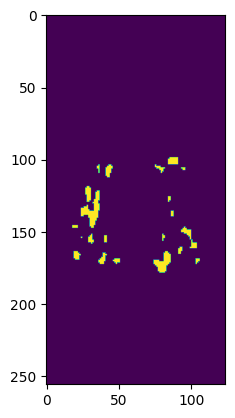

In [132]:
#Save File 
x_s, y_s, z_s = FLAIR_bet_data.shape[0], FLAIR_bet_data.shape[1], FLAIR_bet_data.shape[2]

#final_segmentation = torch.cat(segmentation, dim=0)
ml = 500
cs = 112
seg_ensemble_WMHs = np.zeros((ml, ml))
seg_ensemble_WMHs[int(ml/2-cs):int(ml/2+cs), int(ml/2-cs):int(ml/2+cs)] = result.cpu().pred_sem_seg.values()[0]
plt.imshow(seg_ensemble_WMHs)
seg_ensemble_WMHs = seg_ensemble_WMHs[int(ml/2-y_s/2):int(ml/2+y_s/2), int(ml/2-x_s/2):int(ml/2+x_s/2)]
plt.imshow(seg_ensemble_WMHs)

In [ ]:
#Save File 

final_segmentation = torch.cat(segmentation, dim=0)
final_segmentation = final_segmentation.cpu()
final_segmentation = np.swapaxes(final_segmentation, 0, 2)

ml = 500
cs = 112
seg_ensemble_WMHs = np.zeros((ml, ml, z_s))
seg_ensemble_WMHs[int(ml/2-cs):int(ml/2+cs), int(ml/2-cs):int(ml/2+cs), info[0][0]:info[0][1]+1] = final_segmentation
seg_ensemble_WMHs = seg_ensemble_WMHs[int(ml/2-x_s/2):int(ml/2+x_s/2), int(ml/2-y_s/2):int(ml/2+y_s/2), :]

In [3]:
from functools import partial
from multiprocessing.dummy import Pool
from subprocess import call

path_test = "/home/electroscian/ownCloud/Competencia/Datos_ROBEX/"
CV_test = ["remos_CV0", "remos_CV1", "remos_CV2", "remos_CV3", "remos_CV4", "remos_CV5", "remos_CV6", "remos_CV7", "remos_CV8", "remos_CV9"]
datos_path = "/home/electroscian/ownCloud/Competencia/Datos_ini/"
lista = os.listdir(datos_path)
lista = [str(numb) if len(numb) == 3 else "0"*(3-len(numb)) + str(numb) for numb in lista]

for n,mod in enumerate(CV_test):
    dirs = os.listdir(f"data/WMH_{n}/label/train")
    dirs = [name.replace('.png', '') for name in dirs]
    train_dirs = []
    temp = open("info_test.txt", 'r')
    for line in temp:
        num = line.split('\t')[1]
        filename = str(num) if len(num) == 6 else "0"*(6-len(num)) + str(num)
        if filename in dirs: 
            train_dirs.append(line.split('\t')[0].replace('.nii.gz', ''))
    print(train_dirs)
    run = []
    for value in lista:
        if value not in train_dirs:
            l = len(str(value))
            filename = str(value) + ".nii.gz" if l == 3 else "0"*(3-l) + str(value) + ".nii.gz"
            exec_path = datos_path + "{}".format(value) + "/pre/"
            run.append("bash tools_wmh/remos.sh "+ path_test+"T1/"+filename +" "+ path_test+"FLAIR/"+filename+ " results"+ filename +".nii /home/electroscian/ownCloud/Competencia/Datos_ROBEX/WMH/" + filename +" "+mod)
    pool = Pool(10) # two concurrent commands at a time
    for i, returncode in enumerate(pool.imap(partial(call, shell=True), run)):
        if returncode != 0:
            print("%d command failed: %d" % (i, returncode))

['000', '001', '002', '003', '005', '012', '013', '014', '021', '022', '023', '025', '027', '028', '029', '031', '034', '036', '038', '043', '046', '047', '050', '051', '055', '060', '062', '069', '070', '074', '076', '078', '082', '088', '090', '099', '103', '114', '115', '116', '122', '126', '130', '131', '133', '135', '138', '139', '142', '143', '149', '152', '154', '155', '157', '161', '163', '164', '166', '167']
Loads checkpoint by local backend from path: work_dirs/remos_CV0/iter_80000.pth
Loads checkpoint by local backend from path: work_dirs/remos_CV0/iter_80000.pth
Loads checkpoint by local backend from path: work_dirs/remos_CV0/iter_80000.pth
Loads checkpoint by local backend from path: work_dirs/remos_CV0/iter_80000.pth
Loads checkpoint by local backend from path: work_dirs/remos_CV0/iter_80000.pth
Loads checkpoint by local backend from path: work_dirs/remos_CV0/iter_80000.pth
Loads checkpoint by local backend from path: work_dirs/remos_CV0/iter_80000.pth
Loads checkpoint by

In [48]:
from functools import partial
from multiprocessing.dummy import Pool
from subprocess import call

path_test = "/home/electroscian/ownCloud/Competencia/Datos_ROBEX/"
mod = "uper_remos_wmh"
datos_path = "/home/electroscian/ownCloud/Competencia/Datos_ini/"
lista = os.listdir(datos_path)
lista = [str(numb) if len(numb) == 3 else "0"*(3-len(numb)) + str(numb) for numb in lista]


dirs = os.listdir(f"data/WMH/label/train")
dirs = [name.replace('.png', '') for name in dirs]
train_dirs = []
temp = open("info_test.txt", 'r')
for line in temp:
    num = line.split('\t')[1]
    filename = str(num) if len(num) == 6 else "0"*(6-len(num)) + str(num)
    if filename in dirs: 
        train_dirs.append(line.split('\t')[0].replace('.nii.gz', ''))
print(train_dirs)
run = []
for value in lista:
    #if value not in train_dirs:
    if value == '001':
        l = len(str(value))
        filename = str(value) + ".nii.gz" if l == 3 else "0"*(3-l) + str(value) + ".nii.gz"
        exec_path = datos_path + "{}".format(value) + "/pre/"
        run.append("bash tools_wmh/remos.sh "+ path_test+"T1/"+filename +" "+ path_test+"FLAIR/"+filename+ " results"+ filename +".nii /home/electroscian/ownCloud/Competencia/Datos_ROBEX/WMH/" + filename +" "+mod)
pool = Pool(10) # two concurrent commands at a time
for i, returncode in enumerate(pool.imap(partial(call, shell=True), run)):
    if returncode != 0:
        print("%d command failed: %d" % (i, returncode))

['000', '002', '004', '006', '008', '011', '017', '019', '021', '023', '025', '027', '029', '031', '033', '035', '037', '039', '041', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '112', '113', '114', '115', '116', '126', '132', '137', '144']
Loads checkpoint by local backend from path: work_dirs/uper_remos_wmh/iter_80000.pth
Loads checkpoint by local backend from path: work_dirs/uper_remos_wmh/iter_80000.pth
Loads checkpoint by local backend from path: work_dirs/uper_remos_wmh/iter_80000.pth
Loads checkpoint by local backend from path: work_dirs/uper_remos_wmh/iter_80000.pth
Loads checkpoint by local backend from path: work_dirs/uper_remos_wmh/iter_80000.pth
Loads checkpoint by local backend from path: work_dirs/uper_remos_wmh/iter_80000.pth
Loads checkpoint by local backend from path: work_dirs/uper_remos_wmh

In [11]:
path_test = "/home/electroscian/ownCloud/Competencia/Datos_ROBEX/"
CV_test = ["remos_CV0", "remos_CV1", "remos_CV2", "remos_CV3", "remos_CV4", "remos_CV5", "remos_CV6", "remos_CV7", "remos_CV8", "remos_CV9"]
for n,mod in enumerate(CV_test):
    np.random.seed(n)
    np.random.shuffle(lista)
    
    l = len(train_dirs)
    train_dirs = lista[:l]
    for value in lista:
        if int(value) not in train_dirs:
            l = len(str(value))
            print(value)
            filename = str(value) + ".nii.gz" if l == 3 else "0"*(3-l) + str(value) + ".nii.gz"
            exec_path = datos_path + "{}".format(value) + "/pre/"
            run = subprocess.run(["bash","tools_wmh/remos.sh", path_test+"T1/"+filename, path_test+"FLAIR/"+filename, "results.nii", "/home/electroscian/ownCloud/Competencia/Datos_ROBEX/WMH/" + filename, mod])

166
Loads checkpoint by local backend from path: work_dirs/remos_CV0/iter_80000.pth


KeyboardInterrupt: 

Loads checkpoint by local backend from path: work_dirs/remos_CV0/iter_80000.pth


In [50]:
import pandas as pd
resultados_remos = pd.read_csv("tools_wmh/output/resultados_uper_remos_wmh.txt", header=None)
resultados_remos.columns = ["Dice", "H95", "AVD", "Recall", "F1"]

resultados_pgs = pd.read_csv("tools_wmh/output/PGS_ROBEX_Remos/pgs_results.txt", header=None)
resultados_pgs.columns = ["Dice", "H95", "AVD", "Recall", "F1"]

In [51]:
resultados_remos.describe()

,Dice,H95,AVD,Recall,F1
count,110.000000,110.000000,110.000000,110.000000,110.000000
mean,0.716071,6.592075,58.980826,0.790058,0.696954
std,0.117779,6.659082,51.792955,0.077269,0.084984
min,0.268683,1.355288,6.666667,0.592593,0.436782
25%,0.631382,3.000000,33.832152,0.740402,0.649813
50%,0.723070,3.486606,48.592178,0.789799,0.702714
75%,0.804446,7.736041,69.593903,0.849764,0.759905
max,0.902144,32.838925,422.714681,0.957447,0.878652


In [43]:
resultados_remos.describe()

,Dice,H95,AVD,Recall,F1
count,110.000000,110.000000,110.000000,110.000000,110.000000
mean,0.764496,5.655555,20.928636,0.682990,0.729887
std,0.099935,7.473755,21.391983,0.095487,0.080749
min,0.384229,1.355288,0.000000,0.333333,0.433260
25%,0.713161,2.236068,8.345658,0.629323,0.693684
50%,0.778501,3.000000,16.968666,0.682927,0.735994
75%,0.837042,5.507371,28.106892,0.749550,0.788053
max,0.915304,43.761047,186.426593,0.900000,0.866811


In [19]:
import pandas as pd

resultados_list = os.listdir("/media/electroscian/Datos/Remos_outputs/results/")
resultados_remos = [res for res in resultados_list if res.__contains__('resultados_remos')]
mean_remos = []
total_cv_remos = pd.DataFrame()
for n,remos in enumerate(resultados_remos):
    res_remos = pd.read_csv(f"/media/electroscian/Datos/Remos_outputs/results/{remos}")
    res_remos.columns = ["Dice", "H95", "AVD", "Recall", "F1"]
    mean_remos.append(res_remos.mean())
    res_remos["CV"] = n
    total_cv_remos = pd.concat([total_cv_remos, res_remos])
mean_remos = pd.DataFrame(mean_remos)
mean_remos.describe()
    

,Dice,H95,AVD,Recall,F1
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.770446,5.288909,13.375937,0.660522,0.724173
std,0.005557,0.355963,1.022183,0.011958,0.004851
min,0.763476,4.731634,11.807616,0.638831,0.714520
25%,0.765717,5.005982,13.016900,0.655508,0.721576
50%,0.770243,5.265345,13.293009,0.661488,0.724865
75%,0.775374,5.586782,13.827374,0.668317,0.726530
max,0.778957,5.791031,15.265734,0.675783,0.731721


In [21]:
total_cv_remos.to_csv("stats_cv.csv")

In [4]:
mean_remos

,Dice,H95,AVD,Recall,F1
0,0.765504,5.791031,13.150313,0.645080,0.719745
1,0.766355,5.009498,15.265734,0.675783,0.724728
2,0.776857,5.338807,13.435706,0.654866,0.720822
3,0.777021,5.191884,12.083180,0.657431,0.728637
4,0.763476,5.667479,13.119048,0.638831,0.714520
5,0.770926,5.590551,14.424666,0.668616,0.726011
6,0.770134,4.987923,11.807616,0.674220,0.726703
7,0.778957,4.731634,12.982851,0.660825,0.725003
8,0.770352,5.004810,13.580638,0.667420,0.723840
9,0.764874,5.575476,13.909620,0.662151,0.731721


In [19]:
pd.set_option("display.precision", 3)
mean_remos

,Dice,H95,AVD,Recall,F1
0,0.766,5.009,15.266,0.676,0.725
1,0.763,5.667,13.119,0.639,0.715
2,0.777,5.192,12.083,0.657,0.729
3,0.779,4.732,12.983,0.661,0.725
4,0.766,5.791,13.150,0.645,0.720
5,0.777,5.339,13.436,0.655,0.721
6,0.771,5.591,14.425,0.669,0.726
7,0.770,5.005,13.581,0.667,0.724
8,0.765,5.575,13.910,0.662,0.732
9,0.770,4.988,11.808,0.674,0.727


In [10]:
resultados_pgs.describe()

,Dice,H95,AVD,Recall,F1
count,110.000000,110.000000,110.000000,110.000000,110.000000
mean,0.793834,8.333104,20.623003,0.802977,0.777306
std,0.116410,10.994412,21.999727,0.112031,0.094156
min,0.200000,0.958333,1.270417,0.370370,0.476190
25%,0.761166,2.352119,7.124570,0.763095,0.735545
50%,0.820223,3.152153,15.409673,0.829108,0.798538
75%,0.865437,8.388965,25.369096,0.876645,0.846658
max,0.932074,53.023984,173.684211,0.964029,0.918919


Text(0.5, 1.0, 'Comparación Histogramas Dice PGS vs ReMOS')

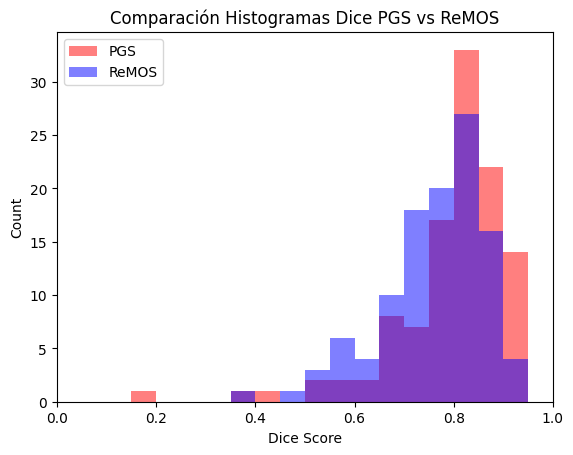

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(resultados_pgs.Dice, alpha = 0.5, lw=3, color= 'r', bins=np.arange(0, 1, 0.05))
ax.hist(resultados_remos.Dice, alpha = 0.5, lw=3, color= 'b', bins=np.arange(0, 1, 0.05))
ax.legend([ "PGS","ReMOS"])
ax.set_xlim([0,1])
ax.set_xlabel("Dice Score")
ax.set_ylabel("Count")
ax.set_title("Comparación Histogramas Dice PGS vs ReMOS")

Text(0.5, 1.0, 'Comparación Histogramas Hausdorff PGS vs ReMOS')

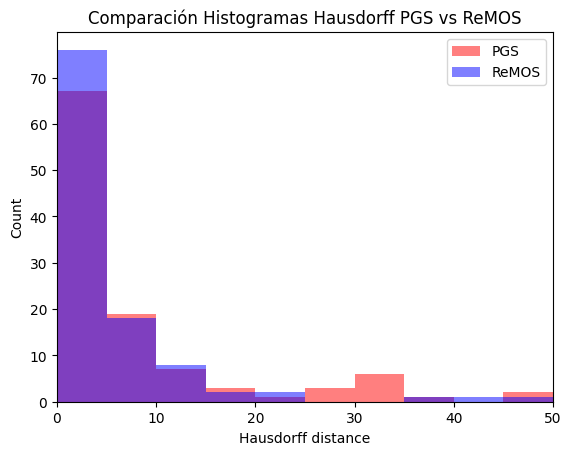

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(resultados_pgs.H95, alpha = 0.5, lw=3, color= 'r', bins=np.arange(0, 55, 5))
ax.hist(resultados_remos.H95, alpha = 0.5, lw=3, color= 'b', bins=np.arange(0, 55, 5))
ax.legend([ "PGS","ReMOS"])
ax.set_xlim([0,50])
ax.set_xlabel("Hausdorff distance")
ax.set_ylabel("Count")
ax.set_title("Comparación Histogramas Hausdorff PGS vs ReMOS")

Text(0.5, 1.0, 'Comparación Histogramas AVD PGS vs ReMOS')

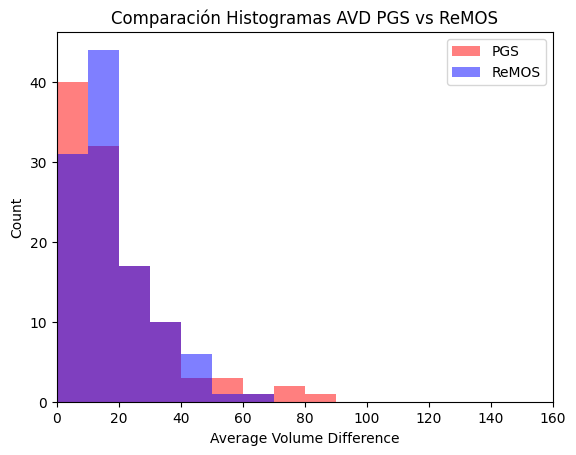

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(resultados_pgs.AVD, alpha = 0.5, lw=3, color= 'r', bins=np.arange(0, 175, 10))
ax.hist(resultados_remos.AVD, alpha = 0.5, lw=3, color= 'b', bins=np.arange(0, 175, 10))
ax.legend([ "PGS","ReMOS"])
ax.set_xlim([0,160])
ax.set_xlabel("Average Volume Difference")
ax.set_ylabel("Count")
ax.set_title("Comparación Histogramas AVD PGS vs ReMOS")

Text(0.5, 1.0, 'Comparación Histogramas Recall PGS vs ReMOS')

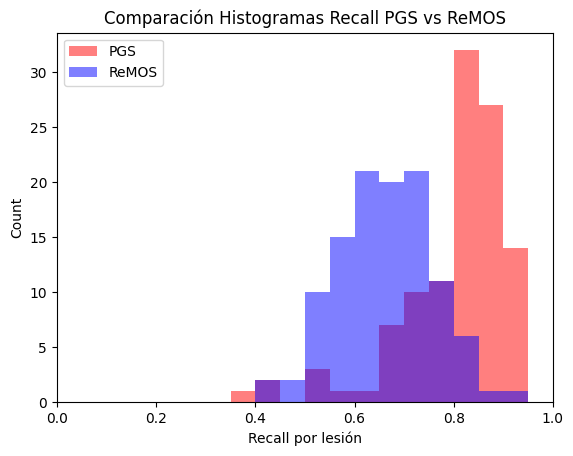

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(resultados_pgs.Recall, alpha = 0.5, lw=3, color= 'r', bins=np.arange(0, 1, 0.05))
ax.hist(resultados_remos.Recall, alpha = 0.5, lw=3, color= 'b', bins=np.arange(0, 1, 0.05))
ax.legend([ "PGS","ReMOS"])
ax.set_xlim([0,1])
ax.set_xlabel("Recall por lesión")
ax.set_ylabel("Count")
ax.set_title("Comparación Histogramas Recall PGS vs ReMOS")

Text(0.5, 1.0, 'Comparación Histogramas F1-Score PGS vs ReMOS')

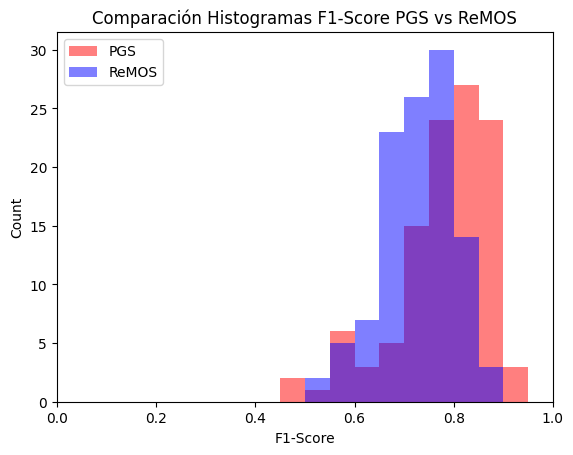

In [104]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(resultados_pgs.F1, alpha = 0.5, lw=3, color= 'r', bins=np.arange(0, 1, 0.05))
ax.hist(resultados_remos.F1, alpha = 0.5, lw=3, color= 'b', bins=np.arange(0, 1, 0.05))
ax.legend([ "PGS","ReMOS"])
ax.set_xlim([0,1])
ax.set_xlabel("F1-Score")
ax.set_ylabel("Count")
ax.set_title("Comparación Histogramas F1-Score PGS vs ReMOS")

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>],
       [<Axes: title={'center': '4'}>, <Axes: >]], dtype=object)

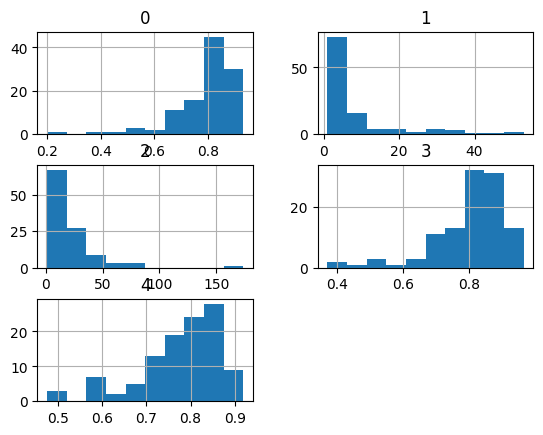

In [34]:
resultados.hist()

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>],
       [<Axes: title={'center': '4'}>, <Axes: >]], dtype=object)

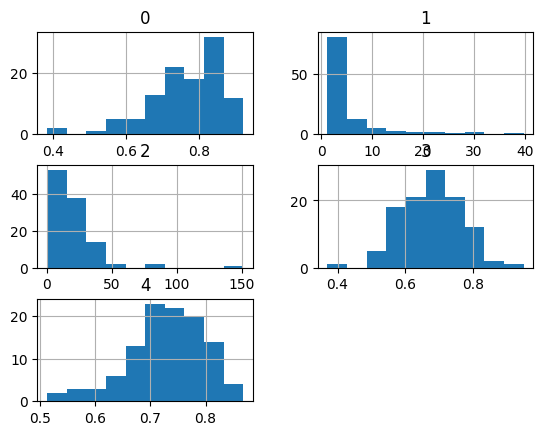

In [12]:
resultados.hist()

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>],
       [<Axes: title={'center': '4'}>, <Axes: >]], dtype=object)

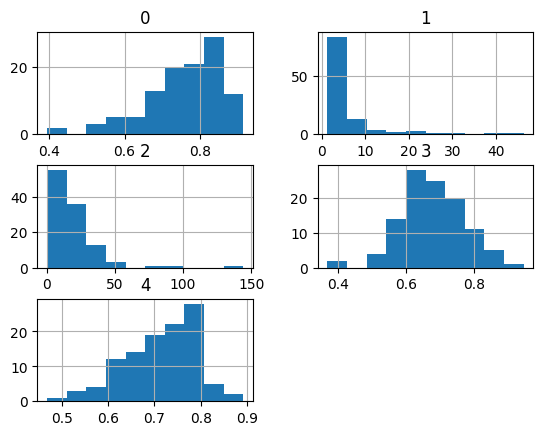

In [15]:
resultados.hist()

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>],
       [<Axes: title={'center': '4'}>, <Axes: >]], dtype=object)

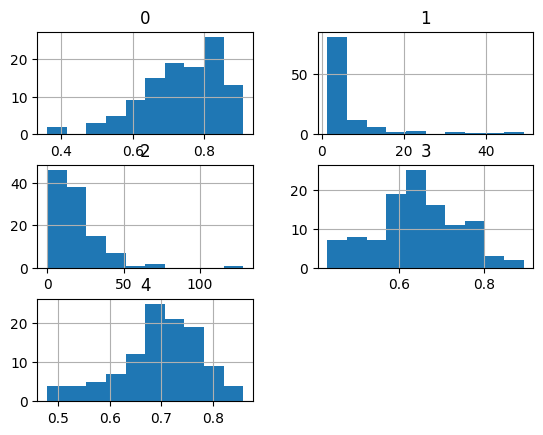

In [18]:
resultados.hist()

In [110]:
lista = [119]
for value in lista:
    l = len(str(value))
    filename = str(value) + ".nii.gz" if l == 3 else "0"*(3-l) + str(value) + ".nii.gz"
    run = subprocess.run(["bash","tools_wmh/remos.sh", path_test+"T1/"+filename, path_test+"FLAIR/"+filename, filename, "/home/electroscian/ownCloud/Competencia/Datos_ROBEX/WMH/" + filename])

Loads checkpoint by local backend from path: work_dirs/uper_remos_wmh/iter_80000.pth
